<a href="https://colab.research.google.com/github/A-Arhami/Alpaca-Recognition-For-Mobile-Phone/blob/main/Alpaca_Classifier_CNN_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with MobileNetV2

In this project we'll be using transfer learning on a pre-trained CNN to build an Alpaca/Not Alpaca classifier!


## Table of Content

- [1 - Packages](#1)
    - [1.1 Create the Dataset and Split it into Training and Validation Sets](#1-1)
- [2 - Preprocess and Augment Training Data](#2)
    - [Exercise 1 - data_augmenter](#ex-1)
- [3 - Using MobileNetV2 for Transfer Learning](#3)
    - [3.1 - Inside a MobileNetV2 Convolutional Building Block](#3-1)
    - [3.2 - Layer Freezing with the Functional API](#3-2)
        - [Exercise 2 - alpaca_model](#ex-2)
    - [3.3 - Fine-tuning the Model](#3-3)
        - [Exercise 3](#ex-3)

<a name='1'></a>
## 1 - Packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


<a name='1-1'></a>
### 1.1 Create the Dataset and Split it into Training and Validation Sets


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


Now let's take a look at some of the images from the training set: 

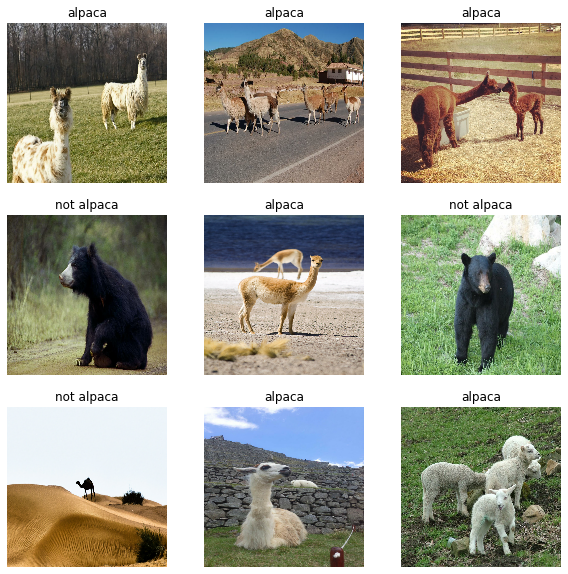

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2'></a>
## 2 - Preprocess and Augment Training Data


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2)) 
    
    return data_augmentation

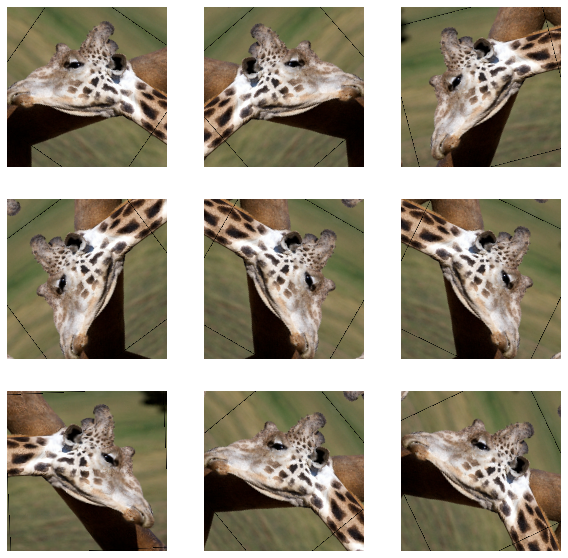

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='3'></a>
## 3 - Using MobileNetV2 for Transfer Learning 

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers

<a name='3-1'></a>
### 3.1 - Inside a MobileNetV2 Convolutional Building Block

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and  depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps: 

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. 



In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14540800/14536120 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

In [ ]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [ ]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

In [ ]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

40960/35363 [==================================] - 0s 0us/step


[[('n04589890', 'window_screen', 0.42582113),
  ('n02708093', 'analog_clock', 0.09275588)],
 [('n04589890', 'window_screen', 0.23985851),
  ('n03887697', 'paper_towel', 0.14802593)],
 [('n04589890', 'window_screen', 0.7449468),
  ('n03598930', 'jigsaw_puzzle', 0.021948555)],
 [('n04589890', 'window_screen', 0.3354602),
  ('n03530642', 'honeycomb', 0.0762895)],
 [('n04589890', 'window_screen', 0.27327338),
  ('n03733281', 'maze', 0.08846959)],
 [('n04589890', 'window_screen', 0.6745217),
  ('n03530642', 'honeycomb', 0.076599255)],
 [('n04589890', 'window_screen', 0.79128474),
  ('n04209239', 'shower_curtain', 0.0924166)],
 [('n04589890', 'window_screen', 0.1646301),
  ('n03598930', 'jigsaw_puzzle', 0.08749153)],
 [('n03598930', 'jigsaw_puzzle', 0.37021384),
  ('n04589890', 'window_screen', 0.099569514)],
 [('n04589890', 'window_screen', 0.6161648),
  ('n03887697', 'paper_towel', 0.054877095)],
 [('n03530642', 'honeycomb', 0.254489),
  ('n04589890', 'window_screen', 0.24874294)],
 [('n04

<a name='3-2'></a>
### 3.2 - Layer Freezing with the Functional API






In [ ]:

def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freezing the base model by making it non trainable
    base_model.trainable = False 

    # creating the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # applying data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # setting training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # adding the new Binary classification layers
    x = tf.keras.layers.GlobalAveragePooling2D ()(x) 
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs =  tfl.Dense(units=1, activation='linear')(x)
    
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 8s 891ms/step - loss: 0.8186 - accuracy: 0.5076 - val_loss: 0.6051 - val_accuracy: 0.5538
Epoch 2/5
9/9 [==============================] - 7s 735ms/step - loss: 0.6087 - accuracy: 0.6565 - val_loss: 0.4615 - val_accuracy: 0.6769
Epoch 3/5
9/9 [==============================] - 7s 791ms/step - loss: 0.5620 - accuracy: 0.6603 - val_loss: 0.4131 - val_accuracy: 0.7385
Epoch 4/5
9/9 [==============================] - 7s 746ms/step - loss: 0.4904 - accuracy: 0.6947 - val_loss: 0.3995 - val_accuracy: 0.6923
Epoch 5/5
9/9 [==============================] - 7s 735ms/step - loss: 0.4550 - accuracy: 0.7481 - val_loss: 0.3017 - val_accuracy: 0.8000


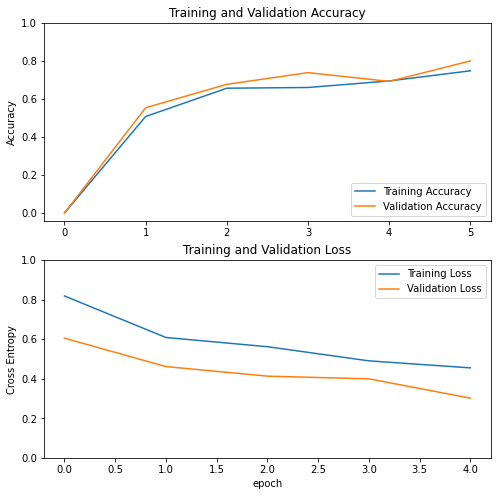

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
class_names

['alpaca', 'not alpaca']

The results are ok, but could be better. Let's try some fine-tuning.





<a name='3-3'></a>
### 3.3 - Fine-tuning the Model


In [ ]:
base_model = model2.layers[4]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120


# Freezing all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Defining a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits = True)
# Defining an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1 * base_learning_rate)
# Useing accuracy as evaluation metric
metrics=['accuracy']


model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  155


In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 9s 1s/step - loss: 0.5370 - accuracy: 0.7443 - val_loss: 0.3045 - val_accuracy: 0.7538
Epoch 6/10
9/9 [==============================] - 9s 977ms/step - loss: 0.3191 - accuracy: 0.8435 - val_loss: 0.1417 - val_accuracy: 0.9692
Epoch 7/10
9/9 [==============================] - 9s 978ms/step - loss: 0.2386 - accuracy: 0.8779 - val_loss: 0.1214 - val_accuracy: 0.9538
Epoch 8/10
9/9 [==============================] - 8s 902ms/step - loss: 0.1854 - accuracy: 0.9198 - val_loss: 0.1025 - val_accuracy: 0.9846
Epoch 9/10
9/9 [==============================] - 8s 924ms/step - loss: 0.1522 - accuracy: 0.9389 - val_loss: 0.1251 - val_accuracy: 0.9846
Epoch 10/10
9/9 [==============================] - 9s 957ms/step - loss: 0.1680 - accuracy: 0.9351 - val_loss: 0.1221 - val_accuracy: 0.9692


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

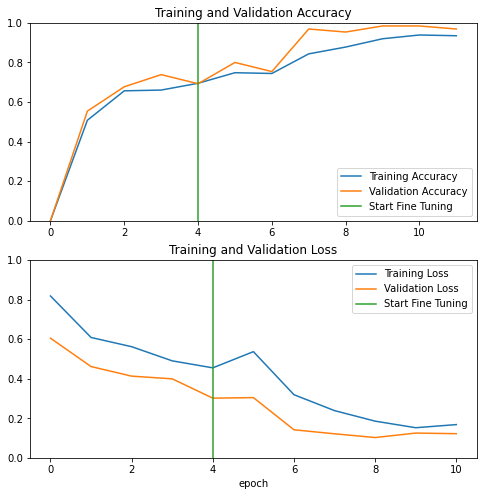

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()